# Variability
The "variability" example and exercise proposed in chapter 10 is explored.

In [1]:
import thinkbayes2
import thinkplot
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/francesco/PersonalProjects/ThinkBayes2/')
from scripts import brfss

Load the data

In [2]:
df = brfss.ReadBrfss('/Users/francesco/PersonalProjects/ThinkBayes2/data/CDBRFS08.ASC.gz')

In [3]:
df.shape

(414509, 6)

In [4]:
df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


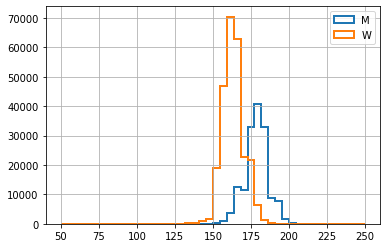

In [5]:
args = {
    'histtype': 'step',
    'linewidth': 2,
    'bins': np.linspace(50,250,45)
}

df[ df['sex']==1 ]['htm3'].hist(label='M', **args);
df[ df['sex']==2 ]['htm3'].hist(label='W', **args);
plt.legend(loc='best');

Summary statistics and coefficient of variation

In [6]:
df['sex'].replace({1: 'M', 2: 'W'}, inplace=True)

In [7]:
df['sex'].value_counts()

W    258806
M    155703
Name: sex, dtype: int64

In [8]:
grouped = df[['sex', 'htm3']].groupby('sex')
for name, group in grouped:
    m = group['htm3'].mean()
    s = group['htm3'].std()
    cv = s/m
    
    print(name, ': mean = {0:.2f}, std = {1:.2f}, cv = {2:.4f}'.format(m, s, cv))

M : mean = 178.07, std = 7.72, cv = 0.0434
W : mean = 163.22, std = 7.27, cv = 0.0445


## Mean and standard deviation
Here the focus is on the actual problem of estimating the mean and the standard deviation of the two populations. In order to do that a smaller sample is used, then the same procedure is applied to the whole dataset to check that indeed the "underflow problem" occurs.

In [52]:
df_data = df[ ~df['htm3'].isna() ].sample(n=100)

In [53]:
df_data['sex'].value_counts()

W    56
M    44
Name: sex, dtype: int64

In [72]:
data = {}
for s in df_data['sex'].unique():
    data[s] = df_data[ df_data['sex']==s ]['htm3'].values

The choice is to model the data of each cohort with a Gaussian distribution (which is legitimate) and the goal is to estimate the parameters of the Gaussians.

**step1**: set some priors on the parameters of the Gaussians. In the book both `mu` and `sigma` are assigned uniform priors, while the range is estimated directly from the data: starting from the mean and the standard deviation of the data and their standard errors, a wider interval is defined.

This is done in `variability.FindPriorRanges(...)`, but for the sake of the exercise, we redo it.

In [73]:
def MakeRange(estimate, stderr, n_points, num_stderrs=3):
    
    spread = num_stderrs * stderr
    return np.linspace(estimate-spread, estimate+spread, n_points)

def FindPriorRanges(values, n_points, num_stderrs=3):
    
    n = len(values)
    
    ### mean
    m = np.mean(values)
    m_stderr = m / math.sqrt(n)
    
    ### standard deviation
    s = np.std(values)
    s_stderr = s / math.sqrt(2*(n-1))
    
    mus = MakeRange(m, m_stderr, n_points, num_stderrs=num_stderrs)
    sigmas = MakeRange(s, s_stderr, n_points, num_stderrs=num_stderrs)
    
    return mus, sigmas

As an example, check one of the two cohorts:

In [74]:
sex = 'M'
mus, sigmas = FindPriorRanges(data[sex], 50, num_stderrs=3)
print('sex:', sex)
print(f'mus: {len(mus)} points, {np.min(mus)} --> {np.max(mus)}')
print(f'sigmas: {len(sigmas)} points, {np.min(sigmas)} --> {np.max(sigmas)}')

sex: M
mus: 50 points, 97.93216768886592 --> 259.6587414020431
sigmas: 50 points, 5.020344336444004 --> 9.821730656044231


Following the example in the book, define an `Height` class:

In [75]:
class Heigth(thinkbayes2.Suite, thinkbayes2.Joint):
    
    def __init__(self, mus, sigmas, label=None):
        '''
        init the class with uniform priors on mu and sigma
        '''
        
        pairs = [ (mu, sigma)
                for mu in mus
                for sigma in sigmas ]
        
        thinkbayes2.Suite.__init__(self, pairs, label=label)
        
    def Likelihood(self, data, hypo):
        
        height = data
        mu, sigma = hypo
        
        like = scipy.stats.norm.pdf(height, mu, sigma)
        
        return like

A few comments:

The uniform prior on `mu` and `sigma` is given "implicitly" by the fact that the `Suite.__init__` method is fed simply with the list of (pairs of) values. A more general approach would be to provide pdfs (or pmfs) for `mu` and `sigma` and feed `Suite.__init__` accordingly.

As usual the `Likelihood` method contains the modelling choice. As stated above the data are modelled with a Gaussian shape and for a given value of the height the question is: given the hypothesis, what is the probability of observing the given height?

Now go on and run the exercise for the two populations:

In [76]:
distr = {}

In [77]:
for sex in data.keys():
    
    mus, sigmas = FindPriorRanges(data[sex], 50, num_stderrs=3)
    
    height = Heigth(mus, sigmas, label=sex)
    
    distr[sex] = height

Check that the priors are indeed uniform

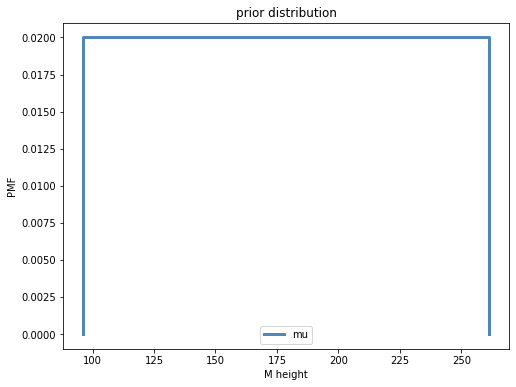

In [78]:
sex = 'M'

thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf(distr[sex].Marginal(0), label='mu')
thinkplot.Config(xlabel=f'{sex} height',
                ylabel='PMF',
                title='prior distribution')

Now update with data:

**Comment**: the cell below indeed crashes because of "all probabilities are zero" already for a total sample size of 150-200 people :\

In [79]:
for sex in distr.keys():
    
    distr[sex].UpdateSet(data[sex])

Check the posteriors:

No handles with labels found to put in legend.


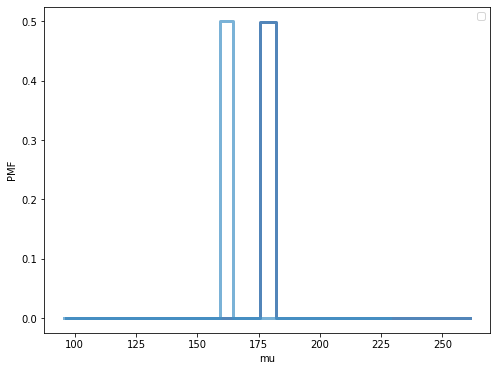

In [80]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs([distr['M'].Marginal(0), distr['W'].Marginal(0)])
thinkplot.Config(xlabel='mu',
                ylabel='PMF')

No handles with labels found to put in legend.


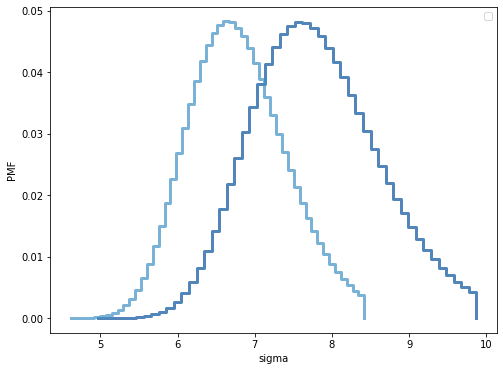

In [81]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs([distr['M'].Marginal(1), distr['W'].Marginal(1)])
thinkplot.Config(xlabel='sigma',
                ylabel='PMF')

In [89]:
for sex in distr.keys():
    
    print('#####', sex)
    print('Maximum likelihood values:')
    print(distr[sex].MaximumLikelihood())

##### M
Maximum likelihood values:
(180.44572570579305, 7.568018710109431)
##### W
Maximum likelihood values:
(163.4514202707669, 6.630756997311022)


These values are not too far from the original ones, given that a much lower statistics is used. Here get the summary statistics out of the "reduced" dataset:

In [90]:
for sex in data.keys():
    m = data[sex].mean()
    s = data[sex].std()
    cv = s/m
    
    print(name, ': mean = {0:.2f}, std = {1:.2f}, cv = {2:.4f}'.format(m, s, cv))

W : mean = 178.80, std = 7.42, cv = 0.0415
W : mean = 162.12, std = 6.52, cv = 0.0402


Numbers are different from the maximum likelihood ones obtained from the posterior!

With the posterior distributions of `mu` and `sigma` it is possible to build the posterior distribution of the coefficient of variation `cv`

In [99]:
def getCV(height, label=None):
    
    pmf = thinkbayes2.Pmf(label=label)
    
    for hypo, prob in height.Items():
        
        mu, sigma = hypo
        
        pmf.Incr(sigma/mu, prob)
    pmf.Normalize()
    return pmf

In [100]:
cvs = {}
for sex in distr.keys():
    cvs[sex] = getCV(distr[sex], label=sex)

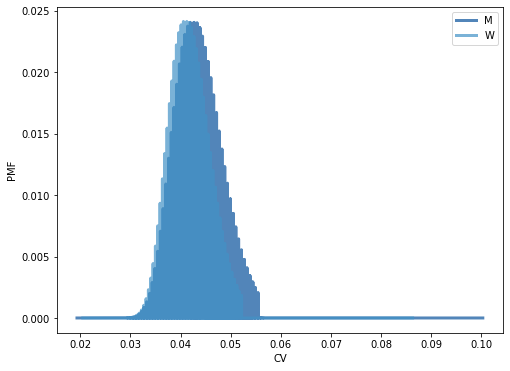

In [101]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pmfs([cvs['M'], cvs['W']])
thinkplot.Config(xlabel='CV',
                ylabel='PMF')